<a href="https://colab.research.google.com/github/kirfinch/product-analytics/blob/main/AK8_1aa_%D0%B5%D1%83%D1%8B%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandahouse
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In C:\Games\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Games\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Games\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Games\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Games\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quali

In [ ]:
connection = {
        'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'database': 'simulator_20211220'
}


q = '''
select user_id,
       exp_group,
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes, 
       likes/views as ctr
from {db}.feed_actions 
where toDate(time) >= '2021-12-08' and toDate(time) <= '2021-12-14' and exp_group in (2,3)
group by user_id, exp_group
'''

df = pandahouse.read_clickhouse(q, connection=connection)

In [ ]:
df

,user_id,exp_group,views,likes,ctr
0,115383,3,36,11,0.305556
1,123580,3,92,15,0.163043
2,131473,2,148,26,0.175676
3,23985,2,66,12,0.181818
4,24523,2,120,17,0.141667
...,...,...,...,...,...
17044,122008,3,31,4,0.129032
17045,25383,2,57,16,0.280702
17046,122190,3,74,25,0.337838
17047,108927,2,33,8,0.242424


In [ ]:
# оценим с помощью t-test есть ли статистически значимые различия между группами 2 и 3, по метрике ctr
# за нулевую гипотезу примем что между 2 и 3 различий нет
t_test_result=stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, equal_var=False)
t_test_result

Ttest_indResult(statistic=-0.739359792495814, pvalue=0.45969873156477636)

pvalue=0.45969873156477636 подтверждает нашу нулевую гипотезу

In [ ]:
rng = 10000
p_val=[]
for i in range(rng):
    # сэмплируем подвыборки с повторением в 500
    sample2=df[df.exp_group == 2].sample(n=500, replace=True) 
    sample3=df[df.exp_group == 3].sample(n=500, replace=True)
    # проводим t-test 
    t_test_result=stats.ttest_ind(sample2.ctr, sample3.ctr, equal_var=False)
    p_val.append(t_test_result[1]) 

<AxesSubplot:>

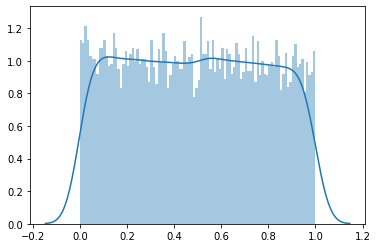

In [ ]:
sns.distplot(p_val, bins=100)

In [ ]:
sum(np.array(p_val) <0.05) / rng

0.0539

Выводы:
На входе мы имели отсплитованные группы 2 и 3. 
'Общий' t-test этих двух групп показал нам, что между ними нет статистически значимых различий и эти две группы можно отдавать на A/B тестирование. 
Проверяя данные на вероятность того, что нулевая гипотеза не верна, а наше значение p-value мы получили случайным образом, попав в 5% хвостов гипотезы 1.
Мы провели 10000 t-test над повыборками в 500 повторений значений группы 2 и 3 из совокупностию
Можно сделать заключение, что в 5,39% случаев нулевая гипотеза отвергается. Иу меня есть сомнения насколько 0,39 % критичны, чтобы точно говорить о качестве сплитования. Конечно хотелось бы провести еще проверки.
Но лично я сделал бы вывод, что система сплитования работает корректно.
